In [14]:
%config IPCompleter.greedy=True
from queue import *

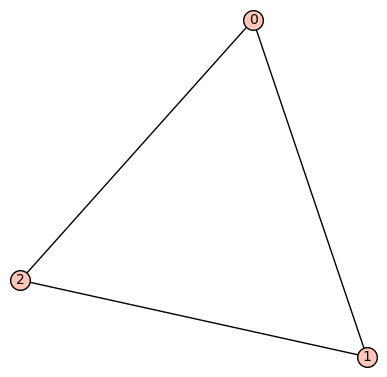

In [81]:
#g = graphs.CycleGraph(4)
g = Graph(3) #Graph({0: [1], 1: [2,3], 3: [4,5]})
g.add_edge(0,1)
g.add_edge(0,2)
g.add_edge(1,2)

#d = g.to_directed()
#list(g.breadth_first_search(0))
#g.vertices()[0]
show(g)



In [82]:
m = Matroid(g)
m.basis
iterator = m.bases()
for i in iterator:
    print(i)

frozenset([(0, 1), (1, 2)])
frozenset([(0, 1), (0, 2)])
frozenset([(1, 2), (0, 2)])


In [83]:
class IndependentSet():
    def __init__(self, g):
        self.G = Graph(g.order())
        self.Treenumbers = [0] * g.order()
        self.Trees = list()
        self.Levelordernumbers = [0] * g.order()
        self.Visited = [False] * g.order()

    def I(self):
        return self.G.edges()

In [84]:
# https://medium.com/100-days-of-algorithms/day-41-union-find-d0027148376d
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [86]:
def rootTree(self, root, treenumber, I):
    d = DiGraph()
    q = Queue()
    q.put(root)
    levelordernumber = 0
    
    while not q.empty():
        v = q.get()
        levelordernumber += 1
        I.Levelordernumbers[v] = levelordernumber
        I.Visited[v] = True
        I.Treenumbers[v] = treenumber
        
        for n in self.neighbor_iterator(v):
            if not I.Visited[n]:
                d.add_edge(v,n)
                q.put(n)
                
    return d
        
Graph.rootTree = rootTree

In [87]:
def c((a,b,_), I):
    if I.Treenumbers[a] != I.Treenumbers[b]:
        return None
    
    cycle = []
    tree = I.Trees[I.Treenumbers[a]]
    
    while I.Levelordernumbers[a] != I.Levelordernumbers[b]:
        if I.Levelordernumbers[a] > I.Levelordernumbers[b]:
            parent = tree.neighbors_in(a)[0]
            if find(I.Disjointsets, parent) != find(I.Disjointsets, a):
                cycle.append((parent, a))
                union(I.Disjointsets, parent, a)
            a = parent
        else:
            parent = tree.neighbors_in(b)[0]
            if find(I.Disjointsets, parent) != find(I.Disjointsets, b):
                cycle.append((parent, b))
                union(I.Disjointsets, parent, b)
            b = parent
    
    #show(tree)
    return cycle

In [88]:
def start(Is):
    for I in Is:
        I.Disjointsets = [i for i in range(I.G.order())]
        components = I.G.connected_components_subgraphs()
        for idx, c in enumerate(components):
            rootedTree = c.rootTree(c.vertices()[0], idx, I)
            I.Trees.append(rootedTree)

In [89]:
def cyclic_scanning(e, k, labels, Is):
    q = Queue()
    q.put(e)
    while not q.empty():
        e = q.get()
        label = labels[e]
        if label == None:
            i = 0
        else:
            (_,i) = label
            i = i + 1
            if i == k:
                i = 0
        cycle = c(e, Is[i])
        if not cycle:
            return ((e,i), labels)
        for f in cycle:
            labels[f] = (e, i)
            q.put(f)
    return (None, labels)

In [90]:
def k_forest(g, k):
    Is = [IndependentSet(g) for i in range(k)]
    start(Is)
    label = None
    for e in g.edges():
        labels = {}
        labels[e] = None
        if label != None:
            start(Is)
        (label, labels) = cyclic_scanning(e, k, labels, Is)
        while label != None:
            (e,i) = label
            Is[i].G.add_edge(e)
            label = labels[e]
    return Is

In [91]:
Is = k_forest(g, 2)
print(Is[0].I())
print(Is[1].I())

[(0, 1, None), (0, 2, None), (1, 2, None)]
[]
